In [1]:
# Code started from https://matteoacrossi.github.io/oqs-jupyterbook/project_1-solution.html

# Imports
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, Aer, execute
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
# qiskit ignis is deprecated. Verification has been migrated to qiskit experiments
from qiskit_experiments.library import StateTomography
from qiskit_experiments.library.tomography import StateTomographyAnalysis

import matplotlib.pyplot as plt
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info.states import DensityMatrix

In [26]:
def depolarizing_channel( qc: QuantumCircuit, p: float, system: QuantumRegister, ancillae: list):
    """Returns a QuantumCircuit implementing depolarizing channel on q[system]
    Returns a copy of the quantum circuit passed in with the depolarizing channel at the end.
    
    Args:
        qc (QuantumCircuit): The quantum circuit to make a copy of and put the depolarizing channel onto.
        p (float): the probability for the channel between 0 and 1.
        system (QuantumRegister): system qubit
        ancillae (list): list of QuantumRegisters for the ancillary qubits. Ancillary qubits are used for the control qubits in the order x, y, then z.

    Returns:
        A QuantumCircuit object
    """
    # Make a copy of the circuit passed in. This circuit will have the depolarizing gates added to the end and then be returned.
    dc = qc.copy()

    # Calculate the theta value which will be used to initialize the ancillary bits to the desired state.
    theta = 1/2 * np.arccos(1-2*p)

    # Initialize ancillary bits
    dc.ry(theta, ancillae[0])
    dc.ry(theta, ancillae[1])
    dc.ry(theta, ancillae[2])

    # Apply depolarizing gates
    dc.cx(ancillae[0], system)
    dc.cy(ancillae[1], system)
    dc.cz(ancillae[2], system)

    return dc

In [42]:
# We create the quantum circuit
q = QuantumRegister(5, name='q')

# Index of the system qubit
system = 2
ancillae=[1,3,4]
ancillae_qubits = [q[i] for i in ancillae]
print(ancillae_qubits)

# Prepare the qubit in a state that has coherence and different populations 
prepare_state = QuantumCircuit(q)
prepare_state.u(np.pi/4, np.pi/4, 0, q[system])

[Qubit(QuantumRegister(5, 'q'), 1), Qubit(QuantumRegister(5, 'q'), 3), Qubit(QuantumRegister(5, 'q'), 4)]


In [41]:
# For example, let's consider 10 equally spaced values of p
p_values = np.linspace(0, 1, 10)

# This is a list of the density matricies for each value of p
tomo_rhos = []

backend = Aer.get_backend('qasm_simulator')
fitter = 'linear_inversion'


# For each value of p we want to look at, build the circuit with that value of p, run the experiment, and put the result in tomo_rhos
for p in p_values:
    circ = depolarizing_channel(prepare_state, p, prepare_state.qubits[system], prepare_state.qubits[ancillae[0]] + prepare_state.qubits[3:])
    tomoExperiment = StateTomography(circ, measurement_indices=[system])
    results = tomoExperiment.run(backend, fitter=fitter).block_for_results()
    tomo_rhos.append(results.analysis_results("state").value.data)


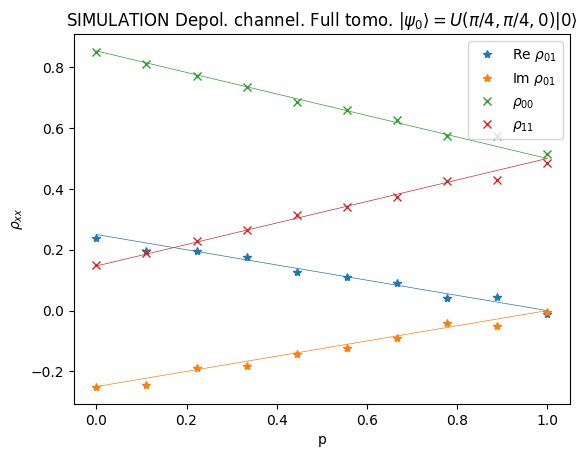

In [39]:

# Split the values from the density matricies into their own arrays for easy graphing
r01 = []
i01 = []
r00 = []
r11 = []

for rho in tomo_rhos:
    r00.append(np.real(rho[0][0]))
    r01.append(np.real(rho[0][1]))
    i01.append(np.imag(rho[0][1]))
    r11.append(np.real(rho[1][1]))

# Simulated results
plt.plot(p_values, r01,"C0*", label='Re $\\rho_{01}$')
plt.plot(p_values, i01,"C1*", label='Im $\\rho_{01}$')
plt.plot(p_values, r00,"C2x", label='$\\rho_{00}$')
plt.plot(p_values, r11,"C3x", label='$\\rho_{11}$')

# Theoretical prediction

# We obtain the density operator of the initial state
rho0 = partial_trace(DensityMatrix.from_instruction(prepare_state), [0, 1, 3, 4]).data

plt.plot(p_values, np.real(rho0[0,1])*(1-p_values), "C0", linewidth=.5)
plt.plot(p_values, np.imag(rho0[0,1])*(1-p_values), "C1", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[0,0])*(1-p_values), "C2", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[1,1])*(1-p_values), "C3", linewidth=.5)

plt.xlabel('p')
plt.ylabel('$\\rho_{xx}$')
plt.legend();

plt.title("SIMULATION Depol. channel. Full tomo. $|\\psi_0\\rangle = U(\\pi/4,\\pi/4,0)|0\\rangle$");